# Обучение сиамской неронной сети с triplete loss для задачи распознования лиц. Few-shot learning

### Файлы для anchor и positive класса были собранны на локальной машине, в качестве класса negative выступает LFW датасет, сюда загружен готовый датасет

Ссылка на LFW: http://vis-www.cs.umass.edu/lfw/#download:~:text=All%20images%20as%20gzipped%20tar%20file 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import cv2 
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2022-12-14 19:04:54.301325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
PATH_colab = os.path.join('/content','drive','MyDrive',"Colab Notebooks",'CV','6_Embeddings','faceid')
PATH = os.path.join('./')
POS_PATH = os.path.join(PATH, 'data', 'positive')
NEG_PATH = os.path.join(PATH, 'data', 'negative')
ANC_PATH = os.path.join(PATH, 'data', 'anchor')

In [5]:
if 0:
    !cd {PATH} && unzip data.zip

In [33]:
#загрузим изображения
anchor = tf.data.Dataset.list_files('./data/anchor/*.jpg').take(500)
positive = tf.data.Dataset.list_files('./data/positive/*.jpg').take(500)
negative = tf.data.Dataset.list_files('./data/negative/*.jpg').take(500)

# '/content/drive/MyDrive/Colab Notebooks/CV/6_Embeddings/faceid/data/anchor/*.jpg'

In [34]:
#собираем tf.Dataset в каждой строчке которого триплеты anchor positive label и anchor negative 0
positives = tf.data.Dataset.zip(\
    (anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip(\
    (anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [35]:
def preprocess(path):
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [36]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [37]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

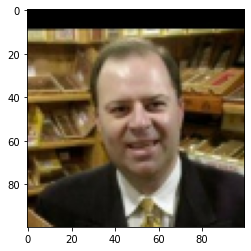

In [38]:
plt.imshow(list(data.as_numpy_iterator())[0][1])

In [48]:
len(list(data.as_numpy_iterator()))

342

In [12]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [13]:
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## построение модели

https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
статья с моделью

In [14]:
# часть стандартнаой сверточной сети которая создаст feature map и отдаст его
# в виде 4096-мерного вектора
def create_embedding():
    inp = Input(shape=(100,100,3), name='inp_img')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m_p1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m_p1)
    m_p2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m_p2)
    m_p3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m_p3)
    
    flatten = Flatten()(c4)
    
    fc1 = Dense(4096, activation='sigmoid')(flatten)
    
#     fc2 = Dense(1, activation='sigmoid')(fc1)
    
    return Model(inputs=[inp], outputs=[fc1], name='embedding')

In [15]:
emb = create_embedding()
emb.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp_img (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [3]:
#Готовим слоий растояния между эмбедингами для сиамской нейросети, который принимает сразу два вектора для 
from scipy.spatial.distance import cosine
class L1Norm(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

class CosNorm(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        normalize_a = tf.nn.l2_normalize(input_embedding,0)        
        normalize_b = tf.nn.l2_normalize(validation_embedding,0)
        cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))

        return cos_similarity

In [4]:
# Финальная сиамская модель с двумя входами и одним выходом классификация похожести
# по растоянию между эмбедингами
def create_siamese_model():
    anc_inp = Input(shape=(100,100,3), name='anchor_img')
    val_inp = Input(shape=(100,100,3), name='validation_img')
    
    siam_layer = L1Norm()
    siam_layer._name = 'distance'
    distances = siam_layer(emb(anc_inp), emb(val_inp))
    
    clf = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[anc_inp, val_inp], outputs=clf, name='SiameseNet')

In [18]:
model = create_siamese_model()

In [19]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.0001)

In [20]:
# собираем стату по обучению модели
ckpt_dir = './training_checkpoints'
ckpt_prefix = os.path.join(ckpt_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=model)

## тренировка сети

In [21]:
@tf.function
def train_step(batch):
    
#     tf.GradientTape сохраняет проделанные сетью операции для 
#     дальнейщего дифференциирования
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
        pred = model(X, training=True)
        
        loss = binary_cross_loss(y, pred) 
    print(loss)
    
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    
    return loss

In [22]:
def train(data, epochs):
    
#     цикл по эпохам
    for epoch in range(1, epochs+1):
        print('\n Epoch {}/{}'.format(epoch, epochs))
        progbar = tf.keras.utils.Progbar(len(data))
        
#     цикл по батчам
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            pred = model.predict(batch[:2])
            progbar.update(idx+1)
        print(loss.numpy())
#     сохраняем чекпоинты
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=ckpt_prefix)

In [23]:
train(train_data, epochs=50)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
15/15 [==============================] - 18s 347ms/step
0.37527886

 Epoch 2/50
15/15 [==============================] - 4s 295ms/step
0.14702949

 Epoch 3/50
15/15 [==============================] - 4s 295ms/step
0.18130118

 Epoch 4/50
15/15 [==============================] - 4s 286ms/step
0.10578963

 Epoch 5/50
15/15 [==============================] - 5s 311ms/step
0.035443194

 Epoch 6/50
15/15 [==============================] - 5s 309ms/step
0.02521119

 Epoch 7/50
15/15 [==============================] - 5s 304ms/step
0.01550211

 Epoch 8/50
15/15 [==============================] - 4s 284ms/step
0.037259564

 Epoch 9/50
15/15 [==============================] - 4s 300ms/step
0.04896203

 Epoch 10/50
15/15 [==============================] - 5s 316ms/step
0.02936446

 Epoch 11/50
15/15 [==============================]

In [63]:
from tensorflow.keras.metrics import Precision, Recall

In [25]:
test_inp, test_val, y_true = test_data.as_numpy_iterator().next()
test_line = test_data.as_numpy_iterator().next()

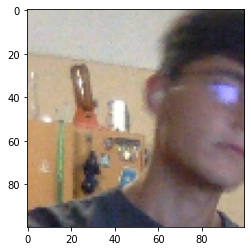

In [26]:
plt.imshow(test_inp[0])

In [27]:
preds = model.predict([test_inp, test_val])

# classification by threshold 
[1 if prediction > .5 else 0 for prediction in preds]

[1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]

In [28]:
y_true

array([1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [29]:
rec = Recall()
rec.update_state(y_true, preds)
rec.result().numpy()

1.0

### Сохраняем веса модели

In [ ]:
with open('out', 'w') as f:
    f.write('/content/drive/MyDrive/Colab Notebooks/CV/6_Embeddings/faceid/defc')

In [30]:
model.save("/content/drive/MyDrive/Colab Notebooks/CV/6_Embeddings/faceid/siamesemodel.h5", )

In [8]:
model = tf.keras.models.load_model('siamesemodel.h5',\
                                  custom_objects={'L1Norm':L1Norm,})

2022-12-14 19:09:34.680414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Протестируем модель, посчитаем метрики на всех примерах которые у нас есть

In [53]:
test_data = data.take(round(len(data)))
test_data = test_data.batch(342)
test_data = test_data.prefetch(8)

test_inp, test_val, y_true = test_data.as_numpy_iterator().next()

In [57]:
preds = model.predict([test_inp, test_val])

# classification by threshold 

11/11 [==============================] - 44s 4s/step


In [66]:
rec = Recall()
rec.update_state(y_true, preds)
recall = rec.result().numpy()
recall

0.9512195

In [67]:
pr = Precision()
pr.update_state(y_true, preds)
precision = pr.result().numpy()
precision

0.9831933

In [69]:
# f1
2*precision*recall/(precision+recall)

0.9669421722789457

In [70]:
test_inp.shape

(342, 100, 100, 3)

### Надо добавить
По хорошему для того чтоб качественно оценить модель надо бы пофоткаться на разных фонах в разной одежде и на разные камеры

Запустим распознование в реально времени

In [ ]:
def verify(frame, model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join(PATH, 'application_data', 'verification_images')):
        input_img = preprocess(os.path.join(PATH, 'application_data', 'input_image', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join(PATH, 'application_data', 'verification_images', image))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result) 

    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join(PATH, 'application_data', 'verification_images'))) 
    verified = verification > verification_threshold

    return results, verified

In [ ]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('FaceId', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()